# Calcuting Pi by Throwing Darts (serial)

In [1]:
import os
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
import numpy as np

In [2]:
def calculate_pi(darts):
    x = np.random.uniform(-1, 1, darts)
    y = np.random.uniform(-1, 1, darts)
    r_sq = x**2 + y**2
    return 4*np.sum(r_sq<1)/darts

In [3]:
calculate_pi(10000)

3.1444

In [4]:
%timeit calculate_pi(10000)

197 µs ± 58.7 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Parallelization with multiprocessing.Process

In [5]:
import multiprocessing
from multiprocessing import Process

In [6]:
def calculate_pi_serial(darts, queue):
    """calculate pi and store it in a queue (serial function)"""
    np.random.seed()
    x = np.random.uniform(-1, 1, darts)
    y = np.random.uniform(-1, 1, darts)
    r_sq = x**2 + y**2
    queue.put(4*np.sum(r_sq<1)/darts)

def calculate_pi_parallel(darts_per_process, Ncores):
    """use the serial function per-process; launch multiple processes"""
    processes = []
    queue = []

    for i in range(Ncores):
        q = multiprocessing.Queue()
        p = Process(target=calculate_pi_serial, args=(darts_per_process,q))
        p.start()
        processes.append(p)
        queue.append(q)
    for p in processes:
        p.join()
        
    total = 0
    for q in queue:
        total += q.get()
    return np.sum(total)/Ncores

In [7]:
calculate_pi_parallel(2500, 4)

3.1348000000000003

In [8]:
%timeit calculate_pi_parallel(2500, 4)

13.7 ms ± 17.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Parallelizing with multiprocessing.Pool

Let's simplify the code a bit by using a Pool instead of a Process.

In [9]:
from multiprocessing import Pool

In [10]:
def calculate_pi_serial(darts):
    """calculate pi and store it in a queue (serial function)"""
    np.random.seed()
    x = np.random.uniform(-1, 1, darts)
    y = np.random.uniform(-1, 1, darts)
    r_sq = x**2 + y**2
    return 4*np.sum(r_sq<1)/darts

def calculate_pi_parallel(darts_per_process, Ncores):
    """use the serial function per-process; launch multiple processes"""
    with Pool(Ncores) as pool:
        results = pool.map(calculate_pi_serial, [darts_per_process for i in range(Ncores)])

    return np.sum(results)/Ncores

In [11]:
calculate_pi_parallel(2500, 4)

3.134

In [12]:
%timeit calculate_pi_parallel(2500, 4)

13.7 ms ± 54 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Parallelization won't work well unless the problem is sufficiently difficult

In [13]:
N = 50_000_000

In [14]:
# it takes about 1.3s to throw 50 mil darts
%timeit calculate_pi_serial(N)

1.31 s ± 301 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
# with 4 processors, you can throw 50 mil darts (12.5 mil each), in ~0.35 secs (~3.7 times faster)
%timeit calculate_pi_parallel(N//4, 4)

353 ms ± 382 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
# with 20 processors, it taks ~0.156 ms, which is only ~8.4 times faster than serial.
# we would need to throw many more darts to get closer to 20X speedup with 20 processors
%timeit calculate_pi_parallel(N//20, 20)

170 ms ± 683 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Scaling: weak vs strong

In [17]:
from timeit import timeit
import matplotlib.pyplot as plt

In [18]:
Ncores = range(1,21)
times = np.array([timeit(lambda: calculate_pi_parallel(N//Nc, Nc), number=1) for Nc in Ncores])

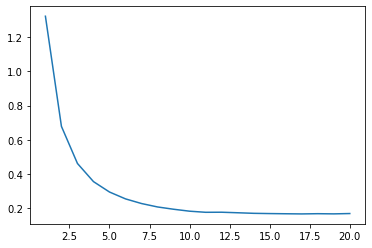

In [19]:
plt.plot(Ncores, times)

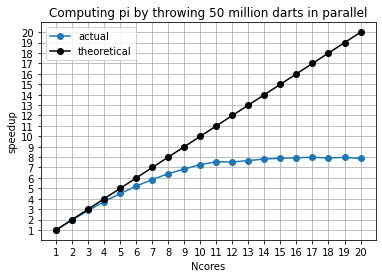

In [25]:
speedup = times[0]/times
plt.plot(Ncores, speedup, 'o-', label='actual')
plt.plot(Ncores, Ncores, 'o-', color='k', label='theoretical')
plt.title('Computing pi by throwing 50 million darts in parallel')
plt.gca().set(xlabel='Ncores', ylabel='speedup', xticks=Ncores, yticks=Ncores);
plt.grid()
plt.legend()

In [26]:
N = 1_000_000
times = np.array([timeit(lambda: calculate_pi_parallel(N//Nc, Nc), number=1) for Nc in Ncores])

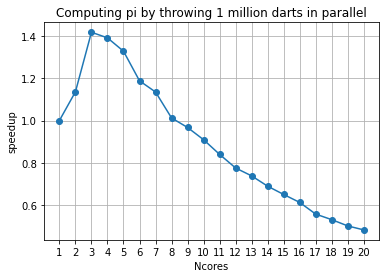

In [32]:
speedup = times[0]/times
plt.plot(Ncores, speedup, 'o-', label='actual')
plt.title('Computing pi by throwing 1 million darts in parallel')
plt.gca().set(xlabel='Ncores', ylabel='speedup', xticks=Ncores);
plt.grid()

In [39]:
N = 250_000_000
times = np.array([timeit(lambda: calculate_pi_parallel(N//Nc, Nc), number=1) for Nc in Ncores])

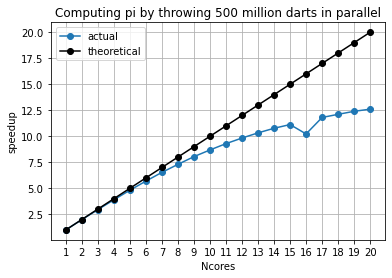

In [40]:
speedup = times[0]/times
plt.plot(Ncores, speedup, 'o-', label='actual')
plt.plot(Ncores, Ncores, 'o-', color='k', label='theoretical')
plt.title('Computing pi by throwing 500 million darts in parallel')
plt.gca().set(xlabel='Ncores', ylabel='speedup', xticks=Ncores);
plt.grid()
plt.legend()